In [99]:
from turtle import distance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist,pdist
from scipy.linalg import svd


def solve_SVD_system(A, b):
    """
    Solve an underdetermined system Ax = b using SVD.

    Parameters:
    A (numpy.ndarray): The coefficient matrix (m x n) where m < n.
    b (numpy.ndarray): The right-hand side vector (m x 1).

    Returns:
    x (numpy.ndarray): The solution vector that minimizes ||Ax - b||2.
    """
    # Perform singular value decomposition (SVD) of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Calculate the pseudo-inverse of A using the SVD components
    S_pseudo = np.diag(1.0 / S)
    A_pseudo = Vt.T @ S_pseudo @ U.T

    # Solve for x using the pseudo-inverse
    x = A_pseudo @ b

    return x


## Define the Cubic function and its integration form


def cubic_double_integration_1d(r):
    return 1/20 * r ** 5

def cubic_integration_1d(r):
    return 1/4*r**4

def cubic_rbf(r):
    return r**3

def cubic_derivative_2d(r):
    r1 = r[:,0]
    r2 = r[:,1]
    return 3*-r1*np.sqrt(r1**2 + r2**2)

def cubic_second_derivative_2d(r):
    r1 = r[:,0]
    r2 = r[:,1]
    return 3*(2*(r1)**2 + (r2)**2)/np.sqrt((r1)**2 + (r2)**2)

    
def IRBFN_1d(X,Y,g,h,H,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    # Create a grid of points for interpolation
    x_max, y_max = np.max(X), np.max(Y)

    x_min = np.min(X)
    x_grid= np.linspace(x_min, x_max, 100)

    n = Y.shape[0]
    m = x_grid.shape[0]

    X_2d = np.hstack((X.reshape(-1,1),np.zeros((n,1))))
    dist_matrix = cdist(X_2d,X_2d)

    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = H(dist_matrix)

    #Add columns for constant C1 and C2
    constant_matrix = np.hstack((X.reshape(-1,1),np.ones(n).reshape(-1,1)))

    full_matrix = np.hstack((RBF_matrix,constant_matrix))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = np.abs(X - x_grid[i])
        H_i = np.hstack((H(distances),x_grid[i],1))
        h_i = np.hstack((h(distances),1))
        g_i = g(distances)
        interpolated_values[i] = np.sum(coefficients * H_i)
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-2] * g_i)

    return x_grid, interpolated_values,interpolated_values_x,interpolated_values_xx

def RBFN_2d(X,Y,g,h,H,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    # Create a grid of points for interpolation
    x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

    x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
    x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))

    n = Y.shape[0]
    m = grid_points.shape[0]

    dist_matrix = cdist(X,X)

    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = g(dist_matrix)

    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(RBF_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i])

        #interpolate original function
        g_i = g(np.linalg.norm(distances,axis=1))
        interpolated_values[i] = np.sum(coefficients * g_i)

        #Derivatives of the interpolation
        H_i = H(distances)
        h_i = h(distances)
        interpolated_values_x[i] = np.sum(coefficients * h_i)
        interpolated_values_xx[i] = np.sum(coefficients * H_i)

    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx


def sample_linear(x,y):
    return x**2 + y

def linear_x(x,y):
    return 2*x

def linear_xx(x,y):
    return 2

# Sample data points and values
X = np.array([list(a) for a in zip(np.linspace(0,100,20),np.linspace(1,50,20))])

Y = sample_linear(X[:,0],X[:,1])
Y_x = linear_x(X[:,0],X[:,1])
Y_xx = linear_xx(X[:,0],X[:,1])

# Interpolate the surface
x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx = RBFN_2d(X, Y,cubic_rbf,cubic_derivative_2d,cubic_second_derivative_2d)



/tmp/ipykernel_8851/2547729243.py:53: RuntimeWarning: invalid value encountered in divide
  return 3*(2*(r1)**2 + (r2)**2)/np.sqrt((r1)**2 + (r2)**2)


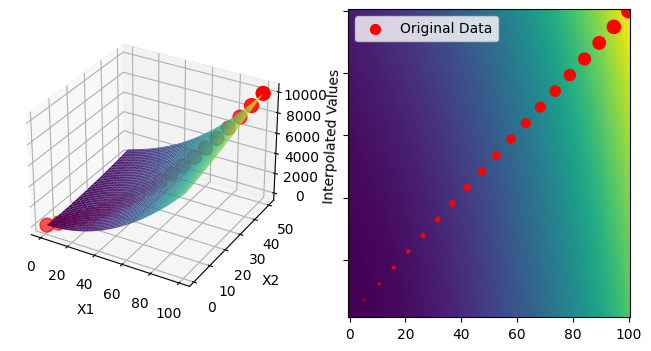

In [100]:
# Plot the interpolated surface
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid, x2_grid, interpolated_values.reshape(x1_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 0], X[:, 1], Y, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(122)
ax2.pcolormesh(x1_grid, x2_grid, interpolated_values.reshape(x1_grid.shape))
ax2.scatter(X[:, 0], X[:, 1], s=Y/100, c='red', label='Original Data')
ax2 = plt.gca()
ax2.set_yticklabels([])



plt.legend()
plt.show()

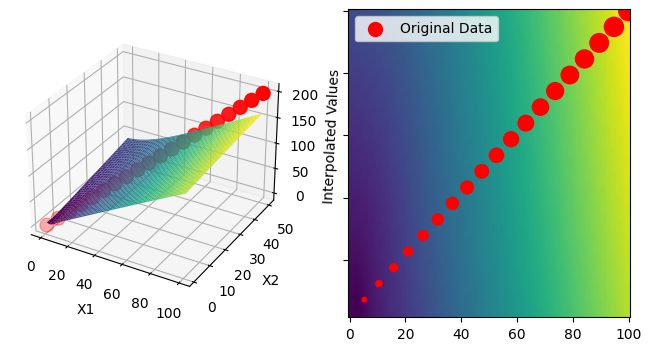

In [101]:
# Plot the interpolated surface
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid, x2_grid, interpolated_values_x.reshape(x1_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 0], X[:, 1], Y_x, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')


ax2 = fig.add_subplot(122)
ax2.pcolormesh(x1_grid, x2_grid, interpolated_values_x.reshape(x1_grid.shape))
ax2.scatter(X[:, 0], X[:, 1], s=Y_x, c='red', label='Original Data')
ax2 = plt.gca()
ax2.set_yticklabels([])



plt.legend()
plt.show()


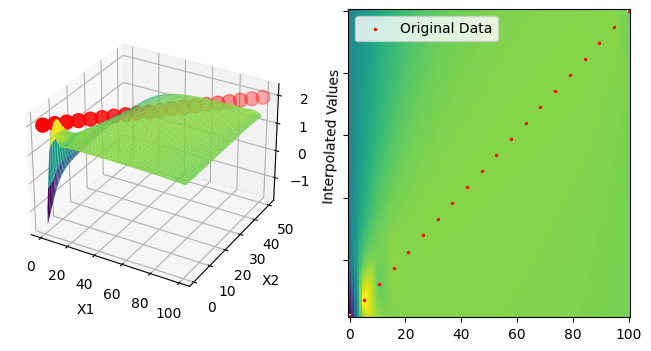

In [102]:
# Plot the interpolated surface
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid, x2_grid, interpolated_values_xx.reshape(x2_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 0], X[:, 1], Y_xx, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(122)
ax2.pcolormesh(x1_grid, x2_grid, interpolated_values_xx.reshape(x1_grid.shape))
ax2.scatter(X[:, 0], X[:, 1], s=Y_xx, c='red', label='Original Data')
ax2 = plt.gca()
ax2.set_yticklabels([])

plt.legend()
plt.show()